In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
codes = pd.read_csv("dataset/codes.csv")


def snomedConvert(code,snomed=True):
    codes = pd.read_csv("dataset/codes.csv")[["Dx","SNOMED CT Code"]]
    
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == x].iloc[0]["Dx"] for x in df.columns]
        return df

In [2]:
df = pd.read_csv("dataset/WFDB_Ga.csv")
df

,6374002,11157007,17338001,27885002,39732003,47665007,49578007,55930002,59118001,59931005,...,429622005,445118002,445211001,698252002,713422000,713426002,713427006,67741000119109,headers,leads
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00001.hea,dataset/WFDB_Ga/E00001.mat
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00002.hea,dataset/WFDB_Ga/E00002.mat
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00003.hea,dataset/WFDB_Ga/E00003.mat
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00004.hea,dataset/WFDB_Ga/E00004.mat
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00005.hea,dataset/WFDB_Ga/E00005.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10339,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10340.hea,dataset/WFDB_Ga/E10340.mat
10340,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10341.hea,dataset/WFDB_Ga/E10341.mat
10341,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10342.hea,dataset/WFDB_Ga/E10342.mat
10342,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,dataset/WFDB_Ga/E10343.hea,dataset/WFDB_Ga/E10343.mat


In [5]:
X = np.load('./dataset/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("dataset/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
y

array([ True, False, False, ..., False, False, False])

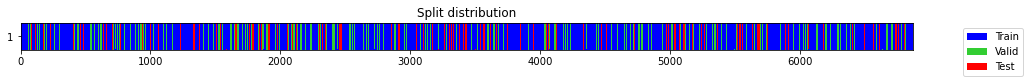

((#4815) [2849,6802,4096,496,2012,173,1178,5343,505,5739...],
 (#1375) [4964,5847,413,6628,1735,5258,6065,3308,3619,3857...],
 (#687) [2626,5678,5053,2717,3363,963,5856,5471,1253,148...])

In [6]:
splits = get_splits(y, valid_size=.2,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,roc_auc_score,time
0,0.528498,0.341301,0.890909,0.862421,0.798387,0.948027,00:09
1,0.299342,0.193865,0.923636,0.883982,0.849354,0.976246,00:08
2,0.213252,0.180491,0.937455,0.909588,0.879888,0.980611,00:09
3,0.177035,0.158236,0.946182,0.929159,0.899457,0.982026,00:09
4,0.153453,0.151077,0.946909,0.929657,0.900680,0.983111,00:09
5,0.142426,0.147000,0.949091,0.933701,0.905149,0.982697,00:08
6,0.125878,0.142446,0.944000,0.920018,0.893204,0.983478,00:08
7,0.111497,0.141143,0.948364,0.931503,0.903401,0.982853,00:09
8,0.101508,0.141104,0.946909,0.931357,0.901218,0.982695,00:09
9,0.094959,0.140616,0.949091,0.933701,0.905149,0.982268,00:09


,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,roc_auc_score
9,0.094959,0.140616,0.949091,0.933701,0.905149,0.982268


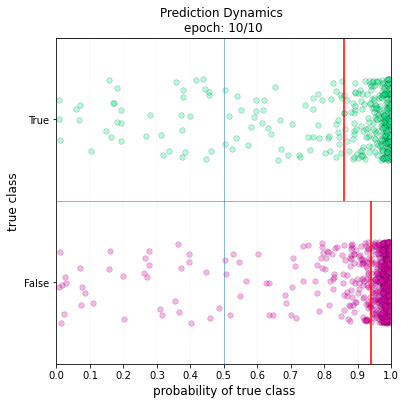

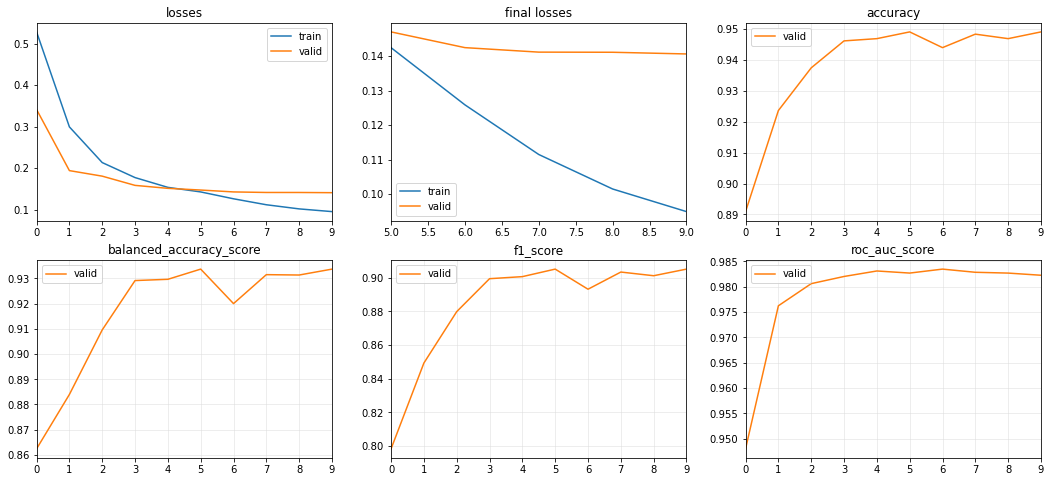

In [17]:
# classifying a single label with inceptiontimeplus
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy, BalancedAccuracy(),F1Score(),RocAucBinary()], cbs=PredictionDynamics())
learn.fit_one_cycle(10, lr_max=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,roc_auc_score,time
0,0.412649,0.292140,0.916364,0.918088,0.856070,0.967164,00:28
1,0.271486,0.200184,0.933091,0.918496,0.877333,0.978348,00:27
2,0.206447,0.178142,0.935273,0.915741,0.879240,0.979484,00:28
3,0.157101,0.178272,0.933818,0.912196,0.875853,0.977822,00:28
4,0.130111,0.156212,0.938909,0.919931,0.885870,0.982923,00:28
5,0.114461,0.141224,0.941818,0.919374,0.889807,0.984853,00:25
6,0.094892,0.137788,0.945455,0.925263,0.897119,0.986338,00:28
7,0.086484,0.135689,0.941818,0.916825,0.888889,0.986885,00:27
8,0.082659,0.135460,0.941818,0.921923,0.890710,0.987025,00:27
9,0.076088,0.134805,0.944000,0.920868,0.893499,0.986910,00:27


,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,roc_auc_score
9,0.076088,0.134805,0.944,0.920868,0.893499,0.98691


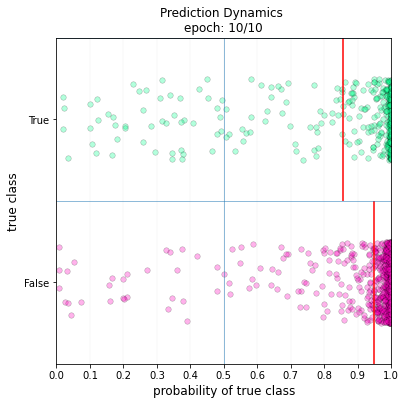

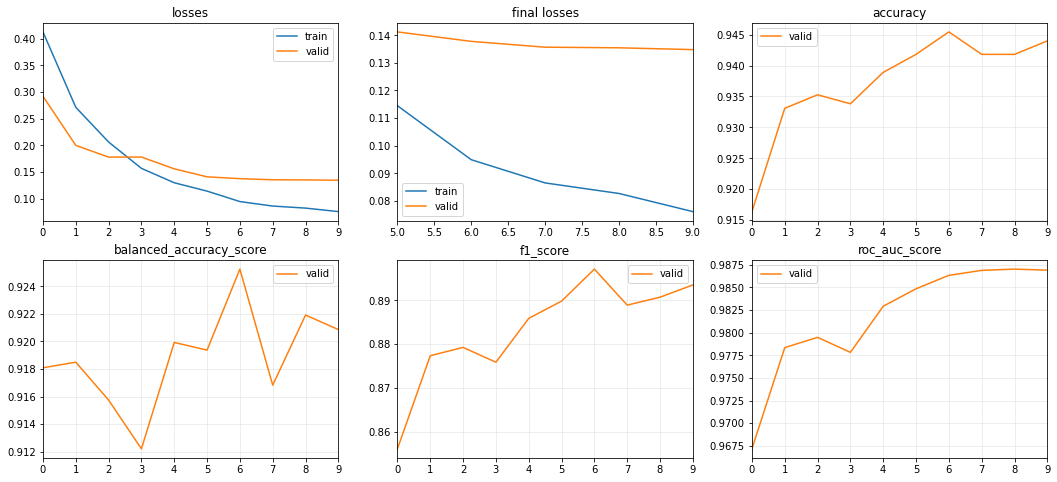

In [14]:
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X.astype(float), y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(MiniRocket, dls=dls)
learn = Learner(dls, model, metrics=[accuracy, BalancedAccuracy(),F1Score(),RocAucBinary()], cbs=PredictionDynamics())
learn.fit_one_cycle(10, lr_max=3e-4)
learn.recorder.plot_metrics()

In [22]:
# classifying a single label with inceptiontimeplus
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
model = XCMPlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy, BalancedAccuracy(),F1Score(),RocAucBinary()], cbs=PredictionDynamics())
learn.fit_one_cycle(10, lr_max=1e-4)
learn.recorder.plot_metrics()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

# multilabel

In [60]:
df = pd.read_csv("dataset/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [142]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)

model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy_multi,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(10, lr_max=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.675920,0.657243,0.550303,0.592772,0.159070,0.648480,0.537063,0.255435,00:06
1,0.642234,0.618621,0.727515,0.637677,0.223082,0.519702,0.755651,0.311993,00:06
2,0.608368,0.583928,0.839596,0.638676,0.341343,0.374944,0.902407,0.356887,00:06
3,0.577003,0.555069,0.888000,0.620599,0.562403,0.269632,0.971567,0.363613,00:06
4,0.549399,0.529884,0.896404,0.604175,0.715933,0.220637,0.987713,0.335879,00:06
5,0.524806,0.507290,0.897939,0.591881,0.803697,0.190183,0.993580,0.306481,00:06
6,0.502608,0.486607,0.898343,0.587076,0.847568,0.178556,0.995596,0.294074,00:06
7,0.481999,0.468004,0.898909,0.586782,0.870896,0.177141,0.996422,0.293546,00:06
8,0.462613,0.448669,0.899071,0.586326,0.882072,0.175861,0.996790,0.292418,00:05
9,0.444670,0.431737,0.900121,0.592816,0.871172,0.189484,0.996148,0.310299,00:06


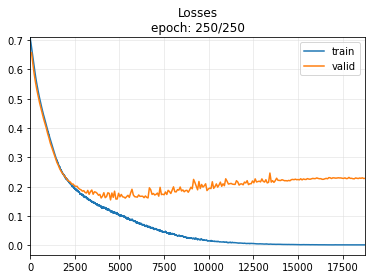

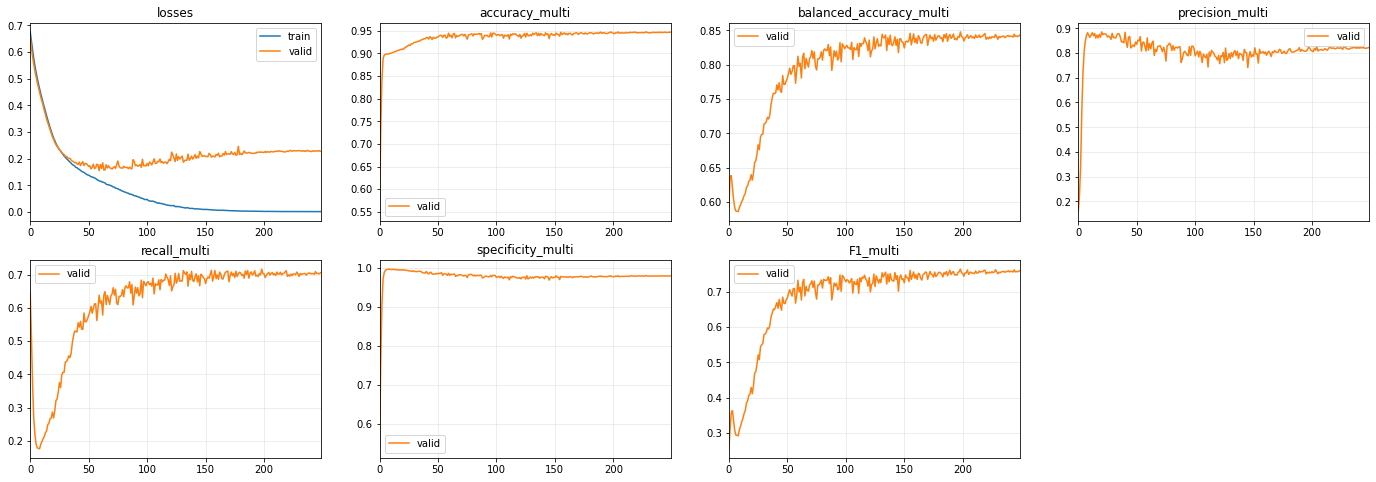

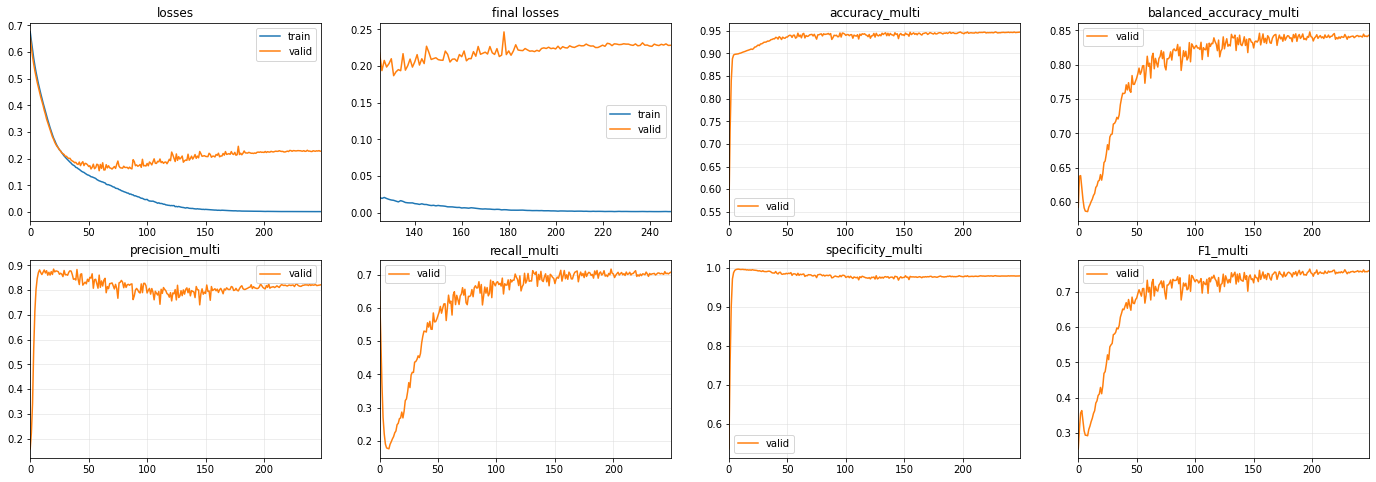

In [163]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(250, lr_max=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.641063,0.622709,0.734545,0.517140,0.136715,0.231761,0.802520,0.171901,00:06
1,0.611511,0.589836,0.809374,0.549670,0.204747,0.208755,0.890586,0.206412,00:06
2,0.582167,0.560949,0.855192,0.571487,0.323437,0.199092,0.943882,0.245412,00:06
3,0.555004,0.533888,0.884525,0.590301,0.542633,0.204070,0.976532,0.294600,00:06
4,0.530924,0.520245,0.895596,0.597700,0.719151,0.206677,0.988723,0.319086,00:06
5,0.508454,0.495510,0.900606,0.604376,0.814572,0.215540,0.993213,0.339641,00:06
6,0.487649,0.470978,0.901899,0.606270,0.844370,0.218225,0.994314,0.345432,00:06
7,0.467874,0.452630,0.901576,0.605750,0.836863,0.217459,0.994040,0.343427,00:06
8,0.449604,0.434276,0.902303,0.604080,0.870022,0.212655,0.995505,0.340089,00:06
9,0.432827,0.419964,0.902141,0.601345,0.882333,0.206543,0.996147,0.333555,00:06


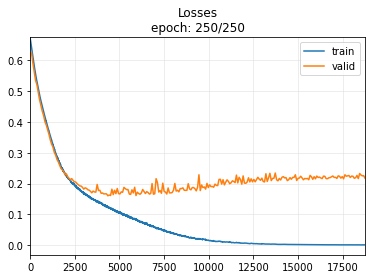

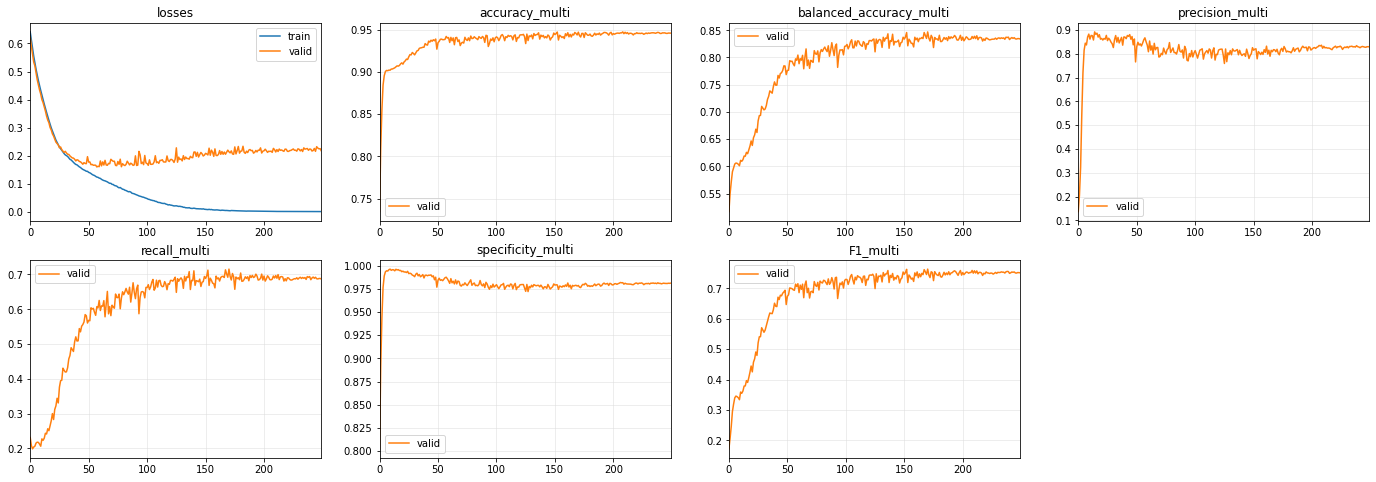

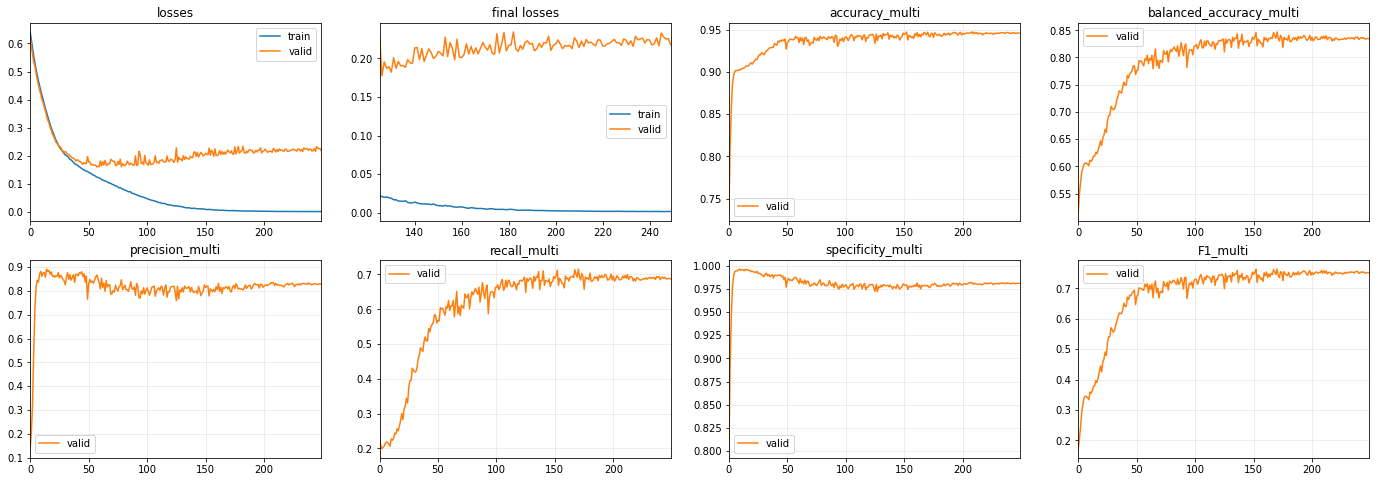

In [164]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True), TSMagScale()]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(250, lr_max=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.692327,0.690091,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:22
1,0.685375,0.688492,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:22
2,0.678732,0.685903,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:21
3,0.672943,0.684019,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:22
4,0.667764,0.681875,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:21
5,0.663128,0.679836,0.591354,0.617137,0.174182,0.650902,0.583372,0.274794,00:22
6,0.658186,0.677223,0.760404,0.616406,0.228727,0.427368,0.805445,0.297936,00:22
7,0.653184,0.675297,0.811556,0.536439,0.187636,0.175339,0.897539,0.181251,00:22
8,0.648089,0.672538,0.811556,0.536439,0.187636,0.175339,0.897539,0.181251,00:22
9,0.642049,0.669194,0.811556,0.536439,0.187636,0.175339,0.897539,0.181251,00:23


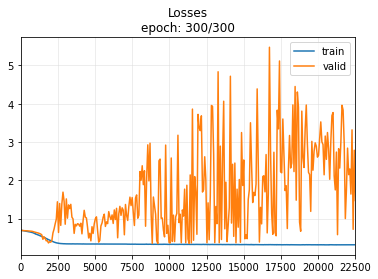

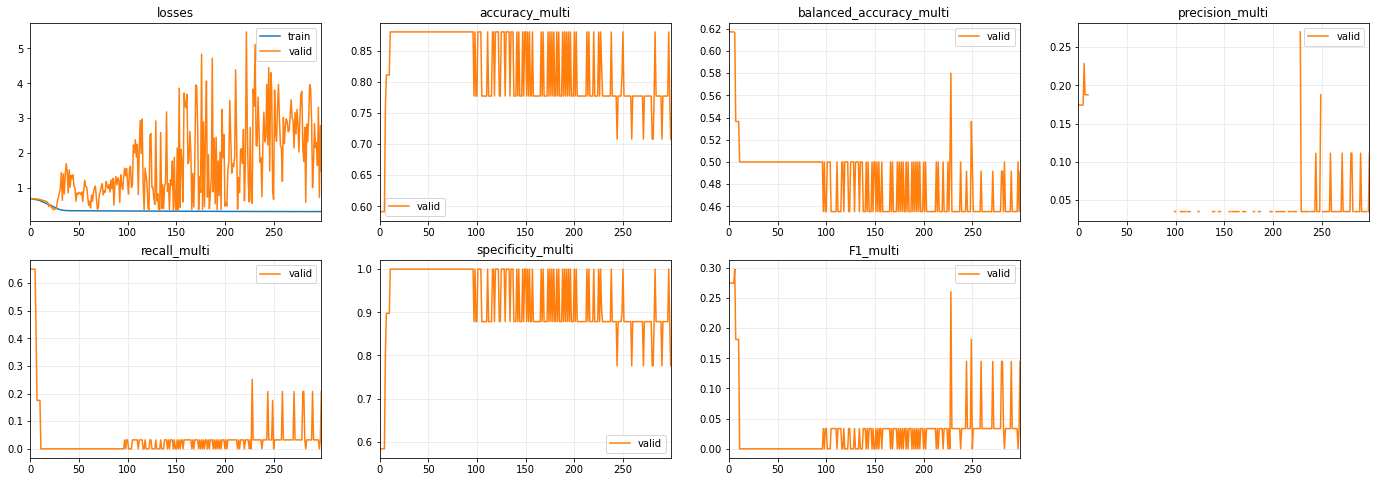

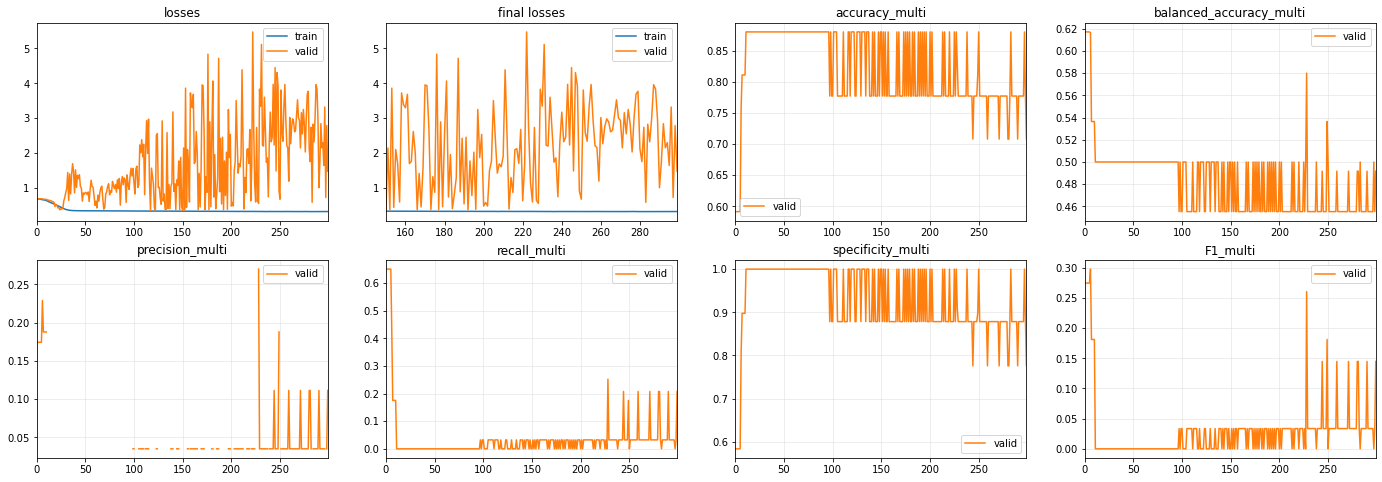

In [165]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True), TSMagScale(),TSWindowWarp()]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(300, lr_max=1e-4)
learn.recorder.plot_metrics()